Импорты

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import pandas as pd
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import winsound

Функция для рисования матрицы ошибок

In [3]:
def plot_conf_matrix(y_test, y_pred, y_train, y_pred_train, model_name):
    classes = ['BI-аналитик,\nаналитик\nданных', 'Бизнес-\nаналитик',
       'Маркетолог-\nаналитик', 'Продуктовый\nаналитик',
       'Руководитель\nотдела\nаналитики', 'Системный\nаналитик',
       'Финансовый\nаналитик,\nинвестиционный\nаналитик']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1, cmap = plt.cm.Blues, normalize = 'true')
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax2, cmap = plt.cm.Blues, normalize = 'true')
    # ax.xaxis.set_ticklabels([1,2,3,4,5,6,7])
    ax1.xaxis.set_ticklabels(classes)
    ax1.yaxis.set_ticklabels(classes)
    ax2.xaxis.set_ticklabels(classes)
    ax2.yaxis.set_ticklabels(classes)
    # ax.yaxis.set_ticklabels(svm_est.classes_)
    ax1.tick_params(axis='x', labelsize=9, labelrotation = 60)
    ax2.tick_params(axis='x', labelsize=9, labelrotation = 60)
    _ = ax1.set_title(
        f"{model_name} (test)")
    _ = ax2.set_title(
        f"{model_name} (train)")

Функция для вывода оценок и матрицы ошибок

In [4]:
def estimation(model, X_test, X_train, y_test, y_train, model_name):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Accuracy Training data: {:.2%}'.format(accuracy_score(y_train, y_pred_train)))
    print('Accuracy Test data: {:.2%}'.format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred, target_names=model.classes_))
    plot_conf_matrix(y_test, y_pred, y_train, y_pred_train, model_name)

Загрузка данных

In [5]:
df_full = pd.read_json('preprocessed_text.json')
df_full['clean_descr'] = df_full['d_wo_sw'].apply(lambda x: ' '.join(x))
df = df_full[['id', 'clean_descr', 'proffesional_roles']].copy()

Добавление тегов и приведение к списку для обучения Doc2Vec

In [6]:
df['tagged'] = df.apply(lambda x: TaggedDocument(x.clean_descr.split(), tags = x.proffesional_roles), axis = 1)
tagged_data = df['tagged'].to_list()
print(len(tagged_data))

23771


Подготовка данных для обучения классификатора

In [7]:
categories = ['Системный аналитик' ,'Продуктовый аналитик', 'Финансовый аналитик, инвестиционный аналитик',
 'Маркетолог-аналитик', 'Бизнес-аналитик', 'BI-аналитик, аналитик данных', 'Руководитель отдела аналитики']
df = df[df['proffesional_roles'].isin(categories)]
df.drop_duplicates(['clean_descr'], inplace=True)
print(len(df))

7383


Обучение модели Doc2Vec 

In [8]:
model = Doc2Vec(tagged_data, dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=4)

2023-05-02 19:08:14,840 : INFO : collecting all words and their counts
2023-05-02 19:08:14,841 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2023-05-02 19:08:16,335 : INFO : PROGRESS: at example #10000, processed 1758712 words (1177997 words/s), 27366 word types, 36 tags
2023-05-02 19:08:17,990 : INFO : PROGRESS: at example #20000, processed 3490077 words (1048360 words/s), 36986 word types, 36 tags
2023-05-02 19:08:18,705 : INFO : collected 39880 word types and 36 unique tags from a corpus of 23771 examples and 4140795 words
2023-05-02 19:08:18,707 : INFO : Creating a fresh vocabulary
2023-05-02 19:08:19,069 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 26451 unique words (66.33% of original 39880, drops 13429)', 'datetime': '2023-05-02T19:08:19.069681', 'gensim': '4.3.0', 'python': '3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepar

Приведение к векторному виду текстов

In [9]:
df['vec'] = df['clean_descr'].apply(lambda x: model.infer_vector(x.split()))

Разделение на train и test

In [10]:
X = np.array(df['vec'].to_list(), dtype = 'float32')
y = df['proffesional_roles'].to_list()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['proffesional_roles'])

Логистическая регрессия

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy Training data: 91.25%
Accuracy Test data: 81.85%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.74      0.71      0.73       235
                             Бизнес-аналитик       0.78      0.79      0.79       571
                         Маркетолог-аналитик       0.83      0.79      0.81       150
                        Продуктовый аналитик       0.67      0.69      0.68       118
               Руководитель отдела аналитики       0.80      0.57      0.67        65
                          Системный аналитик       0.85      0.86      0.86       595
Финансовый аналитик, инвестиционный аналитик       0.91      0.91      0.91       481

                                    accuracy                           0.82      2215
                                   macro avg       0.80      0.76      0.78      2215
                                weighted avg       0.82      0.82      0.82     

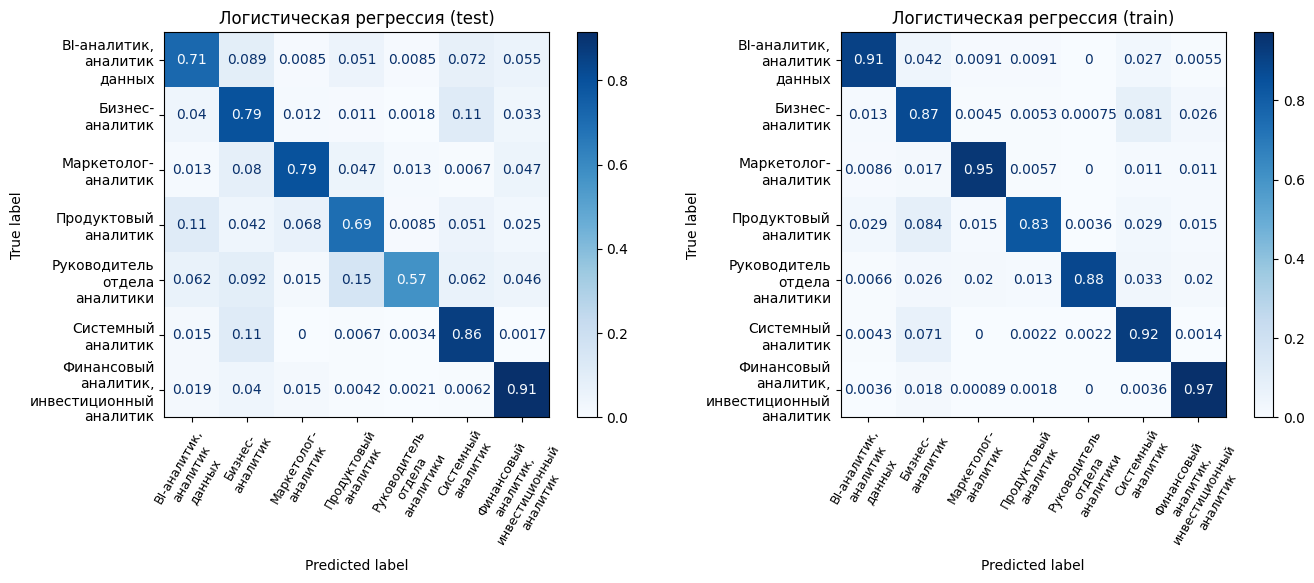

In [14]:
estimation(logreg, X_test, X_train, y_test, y_train, 'Логистическая регрессия')

Подбор параметров для логистической регрессии

In [15]:
logreg = LogisticRegression(max_iter = 150)
class_weight = ['balanced', None]
C = np.logspace(-1, 3, 30)
# penalty = [None, 'l2']
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
parameters = dict(solver = solver, 
                  class_weight = class_weight,
                  C = C)
from sklearn.model_selection import GridSearchCV       

GS_logreg = GridSearchCV(logreg, parameters, n_jobs = 4)
GS_logreg.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=150), n_jobs=4,
             param_grid={'C': array([1.00000000e-01, 1.37382380e-01, 1.88739182e-01, 2.59294380e-01,
       3.56224789e-01, 4.89390092e-01, 6.72335754e-01, 9.23670857e-01,
       1.26896100e+00, 1.74332882e+00, 2.39502662e+00, 3.29034456e+00,
       4.52035366e+00, 6.21016942e+00, 8.53167852e+00, 1.17210230e+01,
       1.61026203e+01, 2.21221629e+01, 3.03919538e+01, 4.17531894e+01,
       5.73615251e+01, 7.88046282e+01, 1.08263673e+02, 1.48735211e+02,
       2.04335972e+02, 2.80721620e+02, 3.85662042e+02, 5.29831691e+02,
       7.27895384e+02, 1.00000000e+03]),
                         'class_weight': ['balanced', None],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']})

In [17]:
# penalty_b = GS_logreg.best_estimator_.get_params()['penalty']
C_b = GS_logreg.best_estimator_.get_params()['C']
class_weight_b = GS_logreg.best_estimator_.get_params()['class_weight']
solver_b = GS_logreg.best_estimator_.get_params()['solver']

# print('Best Penalty:', penalty_b)
print('Best C:', C_b)
print('Best class_weight:', class_weight_b)
print('Best solver:', solver_b)
print(); print(GS_logreg.best_estimator_.get_params())

Best C: 0.18873918221350972
Best class_weight: None
Best solver: lbfgs

{'C': 0.18873918221350972, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 150, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Логистическая регрессия с подобранными параметрами

In [19]:
logreg_est = LogisticRegression(C = C_b,
                                     class_weight = class_weight_b, 
                                     solver = solver_b,
                                     max_iter = 150)
logreg_est.fit(X_train, y_train)

LogisticRegression(C=0.18873918221350972, max_iter=150)

Accuracy Training data: 88.76%
Accuracy Test data: 82.26%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.77      0.74      0.75       235
                             Бизнес-аналитик       0.78      0.80      0.79       571
                         Маркетолог-аналитик       0.78      0.84      0.81       150
                        Продуктовый аналитик       0.72      0.66      0.69       118
               Руководитель отдела аналитики       0.85      0.51      0.63        65
                          Системный аналитик       0.85      0.87      0.86       595
Финансовый аналитик, инвестиционный аналитик       0.89      0.92      0.91       481

                                    accuracy                           0.82      2215
                                   macro avg       0.81      0.76      0.78      2215
                                weighted avg       0.82      0.82      0.82     

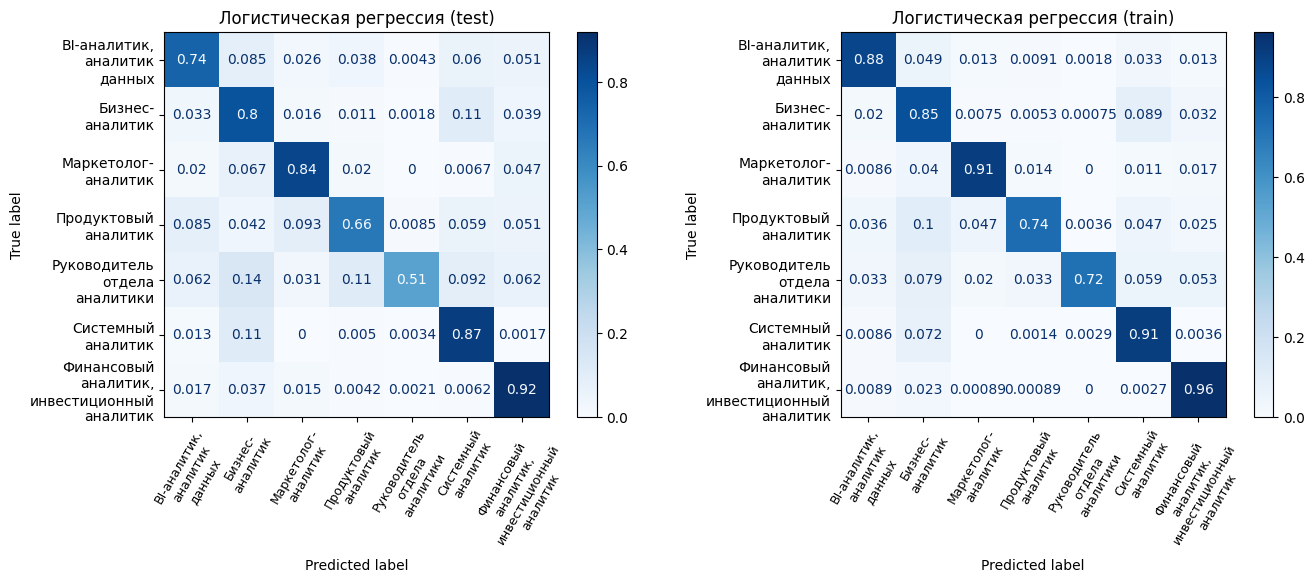

In [20]:
estimation(logreg_est, X_test, X_train, y_test, y_train, 'Логистическая регрессия')

Наивный Байес

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
nb = MultinomialNB()
nb.fit(X_train_scaled, y_train)

MultinomialNB()

Accuracy Training data: 66.31%
Accuracy Test data: 65.24%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.51      0.14      0.22       235
                             Бизнес-аналитик       0.51      0.78      0.62       571
                         Маркетолог-аналитик       1.00      0.13      0.24       150
                        Продуктовый аналитик       1.00      0.03      0.07       118
               Руководитель отдела аналитики       0.00      0.00      0.00        65
                          Системный аналитик       0.74      0.82      0.78       595
Финансовый аналитик, инвестиционный аналитик       0.76      0.94      0.84       481

                                    accuracy                           0.65      2215
                                   macro avg       0.65      0.41      0.39      2215
                                weighted avg       0.67      0.65      0.59     

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

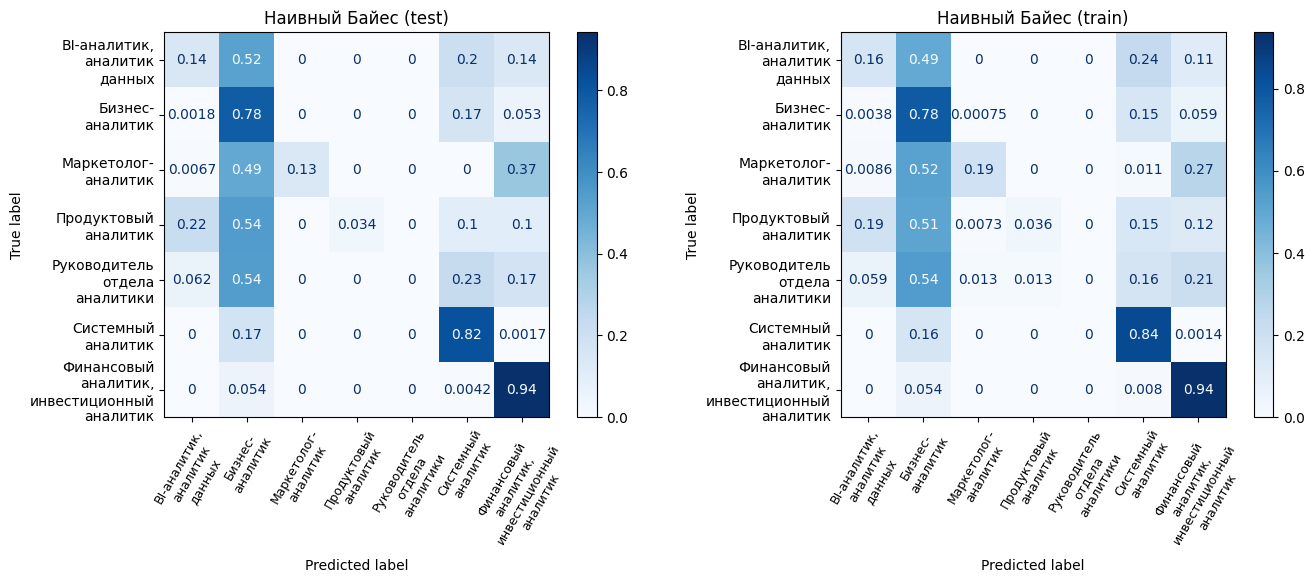

In [23]:
estimation(nb, scaler.transform(X_test), X_train_scaled, y_test, y_train, 'Наивный Байес')

KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
knn = KNeighborsClassifier(n_neighbors=27, p = 1, weights = 'distance', metric='manhattan')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=27, p=1,
                     weights='distance')

Accuracy Training data: 100.00%
Accuracy Test data: 69.84%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.83      0.33      0.47       235
                             Бизнес-аналитик       0.60      0.80      0.68       571
                         Маркетолог-аналитик       0.75      0.57      0.65       150
                        Продуктовый аналитик       0.66      0.60      0.63       118
               Руководитель отдела аналитики       0.00      0.00      0.00        65
                          Системный аналитик       0.85      0.66      0.74       595
Финансовый аналитик, инвестиционный аналитик       0.69      0.97      0.80       481

                                    accuracy                           0.70      2215
                                   macro avg       0.63      0.56      0.57      2215
                                weighted avg       0.71      0.70      0.68    

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

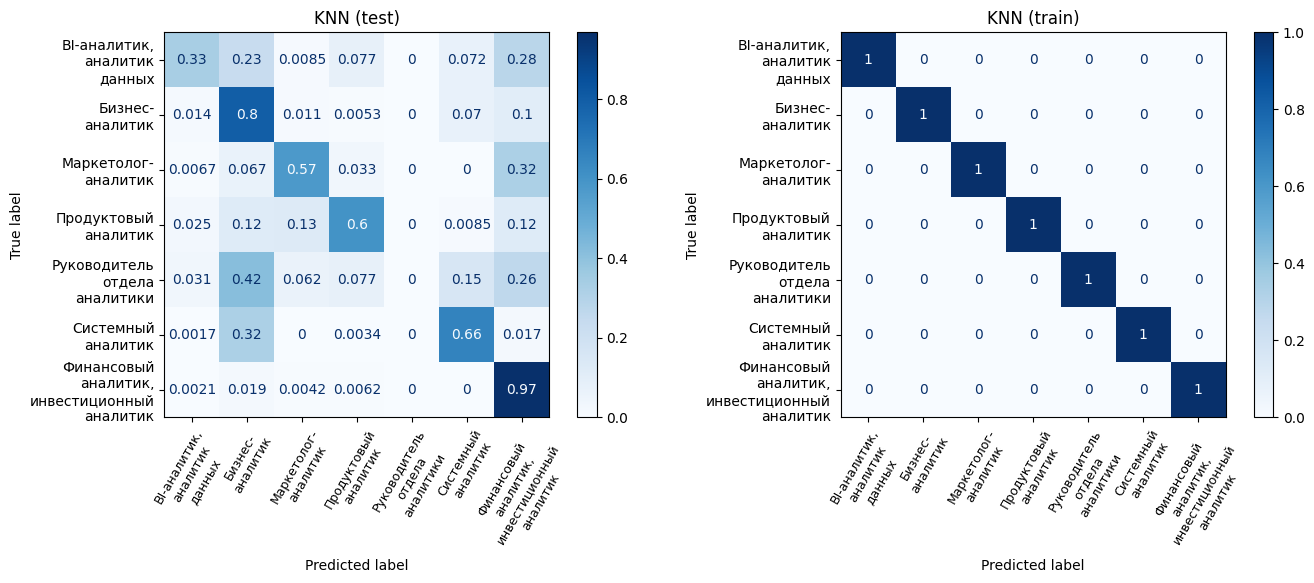

In [26]:
estimation(knn, X_test, X_train, y_test, y_train, 'KNN')

SVM

In [27]:
from sklearn.svm import SVC

In [28]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

Accuracy Training data: 94.68%
Accuracy Test data: 80.68%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.71      0.74      0.73       235
                             Бизнес-аналитик       0.75      0.78      0.76       571
                         Маркетолог-аналитик       0.82      0.79      0.80       150
                        Продуктовый аналитик       0.64      0.64      0.64       118
               Руководитель отдела аналитики       0.79      0.69      0.74        65
                          Системный аналитик       0.85      0.84      0.84       595
Финансовый аналитик, инвестиционный аналитик       0.91      0.90      0.91       481

                                    accuracy                           0.81      2215
                                   macro avg       0.78      0.77      0.77      2215
                                weighted avg       0.81      0.81      0.81     

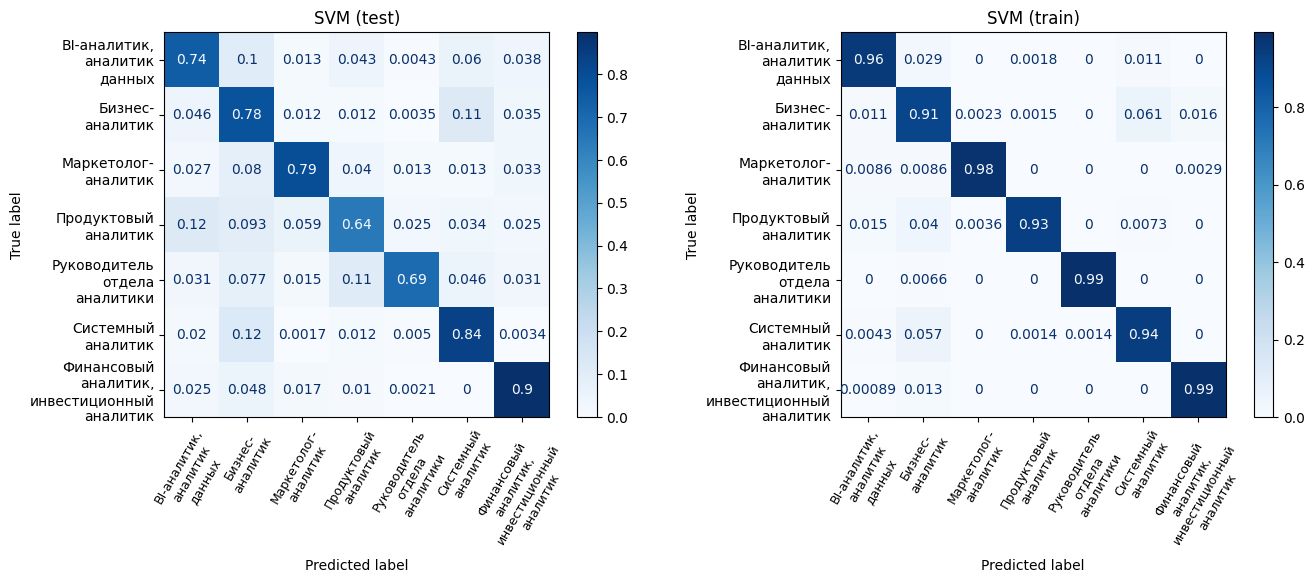

In [29]:
estimation(svm, X_test, X_train, y_test, y_train, 'SVM')

Подбор параметров для SVM

In [30]:
svm = SVC()

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = [0.1, 1, 10, 100, 'scale', 'auto']
C = np.linspace(0, 4, 10)

parameters = dict(kernel = kernel,
                  gamma = gamma, 
                  C = C)       

GS_svm = GridSearchCV(svm, parameters, n_jobs = 4)
GS_svm.fit(X_train, y_train)

kernel_b = GS_svm.best_estimator_.get_params()['kernel']
C_svm_b = GS_svm.best_estimator_.get_params()['C']
gamma_b = GS_svm.best_estimator_.get_params()['gamma']

print('Best Kernel:', kernel_b)
print('Best C:', C_svm_b)
print('Best Gamma:', gamma_b)
print(); print(GS_svm.best_estimator_.get_params())

# winsound.Beep(440, 2000)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py"

Best Kernel: rbf
Best C: 1.7777777777777777
Best Gamma: scale

{'C': 1.7777777777777777, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [31]:
svm_est = SVC(kernel = kernel_b, C = C_svm_b, gamma = gamma_b)
svm_est.fit(X_train, y_train)

SVC(C=1.7777777777777777)

Accuracy Training data: 96.54%
Accuracy Test data: 83.16%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.77      0.76      0.76       235
                             Бизнес-аналитик       0.79      0.81      0.80       571
                         Маркетолог-аналитик       0.81      0.85      0.83       150
                        Продуктовый аналитик       0.76      0.65      0.70       118
               Руководитель отдела аналитики       0.88      0.55      0.68        65
                          Системный аналитик       0.86      0.87      0.86       595
Финансовый аналитик, инвестиционный аналитик       0.90      0.93      0.91       481

                                    accuracy                           0.83      2215
                                   macro avg       0.82      0.77      0.79      2215
                                weighted avg       0.83      0.83      0.83     

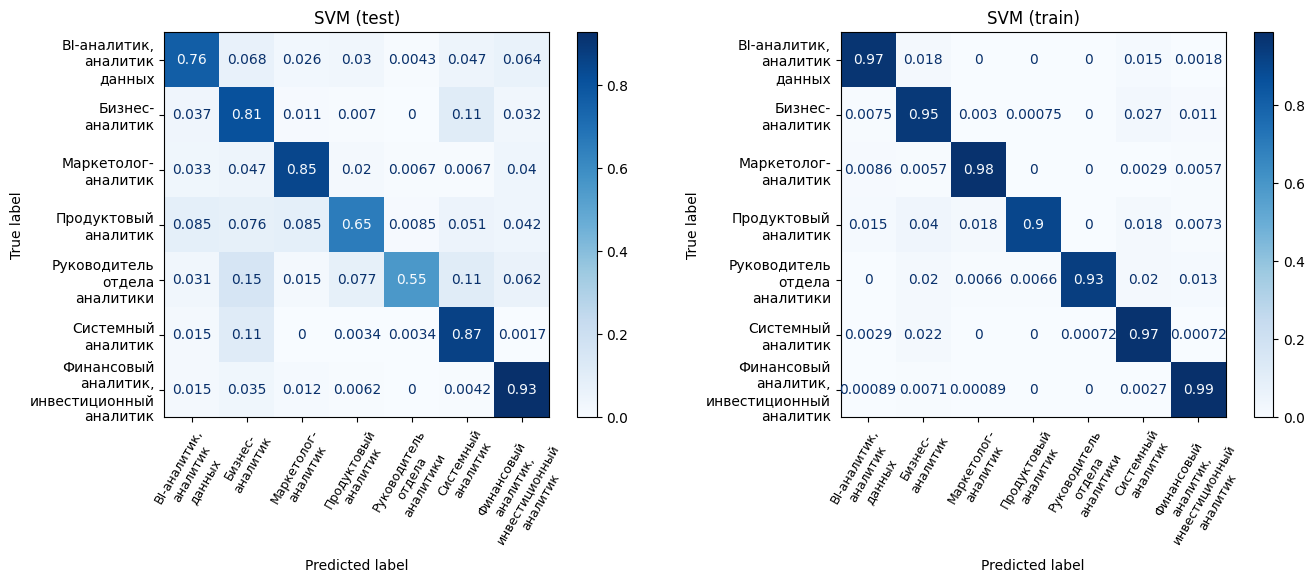

In [32]:
estimation(svm_est, X_test, X_train, y_test, y_train, 'SVM')

Случайный лес

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rand_for = RandomForestClassifier(min_samples_leaf = 10, max_depth=20)
rand_for.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=10)

Accuracy Training data: 90.87%
Accuracy Test data: 70.38%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.61      0.46      0.53       235
                             Бизнес-аналитик       0.62      0.73      0.67       571
                         Маркетолог-аналитик       0.89      0.39      0.55       150
                        Продуктовый аналитик       0.88      0.13      0.22       118
               Руководитель отдела аналитики       0.00      0.00      0.00        65
                          Системный аналитик       0.75      0.85      0.80       595
Финансовый аналитик, инвестиционный аналитик       0.75      0.94      0.83       481

                                    accuracy                           0.70      2215
                                   macro avg       0.64      0.50      0.51      2215
                                weighted avg       0.70      0.70      0.67     

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

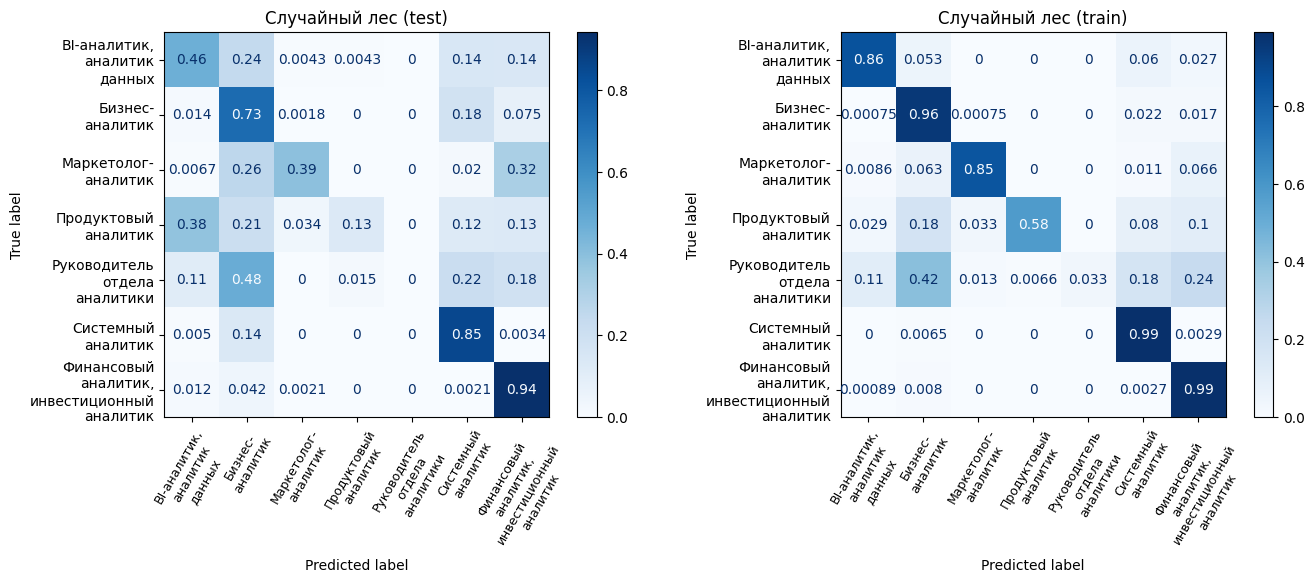

In [35]:
estimation(rand_for, X_test, X_train, y_test, y_train, 'Случайный лес')

Классификация неразмеченных вакансий

In [39]:
df_to_predict = df_full[['id', 'clean_descr', 'proffesional_roles']].copy()

In [40]:
df_to_predict['predicted'] = np.nan

In [62]:
df_to_predict['vec'] = df_to_predict['clean_descr'][~df_to_predict['proffesional_roles'].isin(categories)].apply(lambda x: model.infer_vector(x.split()))

In [76]:
df_to_predict['predicted'][~df_to_predict['proffesional_roles'].isin(categories)] = svm_est.predict(df_to_predict['vec'][~df_to_predict['proffesional_roles'].isin(categories)].to_list())

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2732\1648195239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['predicted'][~df_to_predict['proffesional_roles'].isin(categories)] = svm_est.predict(df_to_predict['vec'][~df_to_predict['proffesional_roles'].isin(categories)].to_list())


In [84]:
df_to_predict['predicted'][df_to_predict['predicted'].isna() == True] = df_to_predict['proffesional_roles'][df_to_predict['predicted'].isna() == True] 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2732\577855633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['predicted'][df_to_predict['predicted'].isna() == True] = df_to_predict['proffesional_roles'][df_to_predict['predicted'].isna() == True]


Соединение с остальными столбцами датасета

In [87]:
skills = pd.read_json('extracted_skills.json')

In [90]:
df_to_add = pd.read_json('deduplicated.json')

In [93]:
part1 = pd.merge(df_to_predict[['id', 'predicted']], skills[['id', 'extracted_skills']], how = 'inner', left_on = 'id', right_on = 'id')

In [124]:
result = pd.merge(part1[['id', 'predicted', 'extracted_skills']], df_to_add[['id', 'name', 'area', 'employment', 'experience', 'publication_date', 'salary', 'schedule', 'employer']])

In [125]:
result.rename(columns={'predicted': 'proffesional_roles'}, inplace = True)

Преобразование поля зарплата

In [126]:
def salary(salary, gross = None, currency = None):
    salary_res = None
    if salary != None:
        if gross == True:
            salary_res = salary * 0.83 if salary != None else None
        else:
            salary_res = salary
        if currency == 'EUR':
            salary_res = salary_res * 88
        elif currency == 'USD':
            salary_res = salary_res * 80
    return salary_res

In [127]:
result['salary_from'] = result['salary'].apply(lambda x: salary(x['from'], x['gross'], x['currency']) if x != None else salary(x))
result['salary_to'] = result['salary'].apply(lambda x: salary(x['to'], x['gross'], x['currency']) if x != None else salary(x))
result['currency'] = result['salary'].apply(lambda x: x['currency'] if x != None else None)
result.drop(['salary'], axis = 1, inplace = True)

Сохранение данных

In [128]:
result.to_csv('vac_for_vis.csv', sep = ';')

In [130]:
result2 = result.explode('extracted_skills').copy()

In [131]:
result2.to_csv('vac_for_vis_skills.csv')

(0.0, 8500.0)

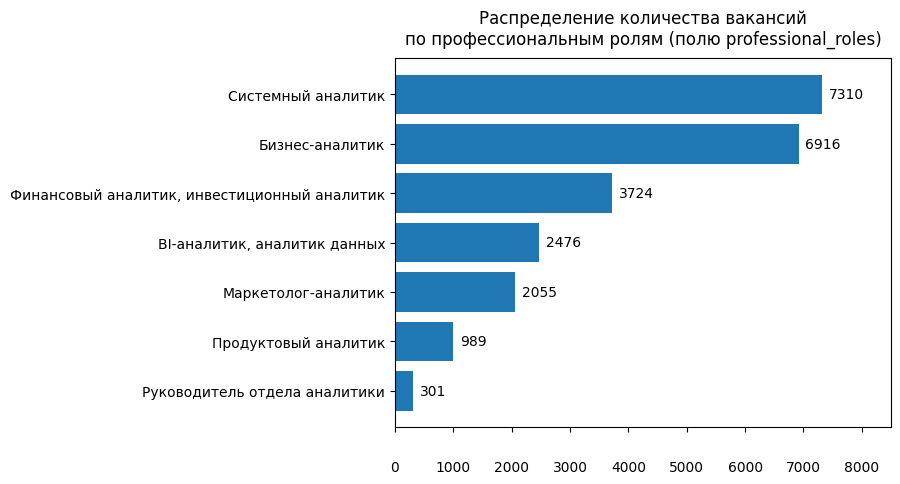

In [132]:
y = df_to_predict["predicted"].value_counts().sort_values(ascending = True).index
x = df_to_predict["predicted"].value_counts().sort_values(ascending = True)
fig, ax = plt.subplots()
hbars = ax.barh(y, x, align='center')
# ax.set_yticks(y, labels=x)
ax.xaxis.set_tick_params(pad = 20)
ax.bar_label(hbars, padding = 5)
ax.set_title('Распределение количества вакансий\nпо профессиональным ролям (полю professional_roles)', loc = 'center', pad = 10)
ax.set_xlim(right=8500)